# Tutorial #2: Cantera and User-Defined Functions

__Motivation:__

Now is the point in this course where we will introduce and use the Cantera software package to perform detailed
 kinetic simulations.
Some of you may have previously used Cantera in Thermodynamics to access thermodynamic data and view equilibrium
 chemistry.
Regardless of whether you have had previous exposure, here we're going to introduce you to the chemical-kinetic
 capabilities of Cantera and guide you through using them.

## 1. User-Defined Functions

Prior to launching into Cantera, we first take a moment to introduce user-defined functions.
Defining functions allows for modularizing and reusing code, which greatly simplifies the implementation of complex
 computational tasks.

The basic form for defining a function in Python is as follows:
```
def <function_name>(<args*>, <kwargs**>):
    code...
    ...
    ...
    return <return variable(s)>
```

In this form:
* `def` is the keyword that tells Python we are defining a function
* `<function_name>` is the name we will use to reference our new function
* `<args*>` is a list of required arguments (variables) that are:
  * required by the function
  * provided to the function in a pre-determined order
* `<kwargs*>` is a list of keyword arguments that are:
  * optional whether you provide them when running the function
  * specified with a default value that is used if no other value is provided
* `:` ends the function definition line
* whitespace: code within a function must be consistently padded by whitespace
  * Python interprets encountering non-tabbed code as having reached the end of the function
* `return` keyword passes the argument(s) listed after it back to the calling code
  * If more than one value is listed, the values are grouped and returned as a tuple

Let's look at some example function definitions, starting with the area of a triangle

In [398]:
def triangle_area(base, height):
    return 0.5 * base * height

triangle_area(3, 2)

3.0

That wasn't so hard!

While this example is pretty trivial, it let's us see how we might use it to implement more advanced functionality, like
 input validation.

In [399]:
def triangle_area(base, height):
    if base < 0 or height < 0:
        raise Exception('Base and height of a triangle must be non-negative')
    return 0.5 * base * height

print(triangle_area(3, 2))
# print(triangle_area(-3, 2))

3.0


We know that the dimensions of a triangle have to be positive, so we can check for that and `raise` a custom `Exception`
 message if a negative value is encountered.

To illustrate the use of keyword arguments, imagine we want to compute points along a line of the form `y = mx + b`,
 and let's assume that `b` is _usually_ zero.
We want to make our function generalizable (i.e. be _able_ to specify other values of `b`), but we don't want to have to
 enter `b` in all the cases where it is, in fact, zero.

In [400]:
def y(m, x, b=0):
    return m * x + b

print(y(2, 3))
print(y(0, 2))
print(y(0, 2, b=1.))

6
0
1.0


In the first two cases, we don't specify a value for `b`, and the default of zero is used.
In the final example, the value of `b` is overwritten by providing a keyword argument.

## 2. Cantera

We are finally here, ready to introduce Cantera for Python.
The material covered in this tutorial is not meant to be comprehensive, but should cover what you need to know to do the
 problem set.
We additionally hope this material will allow you to get you feet wet enough to be able to start making sense of the
 documentation, describing the full functionality of Cantera, which can be found here:
[Cantera Documentation](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/index.html)

For consistency, we always import Cantera using the name `ct`.
We will also go ahead and import some additional useful packages right away.

In [401]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os

### 2a. Initialize a solution object

For this example, we will use the "Stanford Mechanism v1.2".
This mechanism is not built-in to Cantera (the way 'GRI Mech 3.0' is), so we must get the file path to the mechanism
 '.cti' file stored elsewhere in the repository.

In [402]:
mech_file = os.path.abspath('../mechanisms/stanford-mech_v12.cti')
mech_file

'C:\\Users\\asusa\\pycharm_projects\\me362b_winter2021\\mechanisms\\stanford-mech_v12.cti'

We can now pass this filepath as an argument to the `ct.Solution` class to create an instance of the class based on this
 mechanism.

Placing empty parenthesis `()` after the Solution instance name produces an output of it's state.

In [403]:
gas = ct.Solution(mech_file)
gas()


  Stanford_v1.2:

       temperature             300  K
          pressure          101325  Pa
           density       0.0818891  kg/m^3
  mean mol. weight         2.01588  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy           26470        5.336e+04     J
   internal energy     -1.2109e+06       -2.441e+06     J
           entropy           64914        1.309e+05     J/K
    Gibbs function     -1.9448e+07        -3.92e+07     J
 heat capacity c_p           14312        2.885e+04     J/K
 heat capacity c_v           10187        2.054e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2              1                1         -15.7173
     [   +9 minor]              0                0



### 2b. Accessing and assigning state variables

Properties, accessed with dot notation but without `()` or arguments, are used to access state properies of `gas`

In [404]:
print(f'T = {gas.T:3.1f} K')
print(f'P = {gas.P:3.0f} Pa')
print(f'rho = {gas.density_mass:5.4f} kg/m^3')
print(f'TPX = {gas.TPX}')

T = 300.0 K
P = 101325 Pa
rho = 0.0819 kg/m^3
TPX = (300.0, 101324.99999999999, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


We can also set properties through assignment.
We cannot assign temperature or pressure one at a time, as it would result in ambiguity as to what constraint to
 enforce (constant volume, constant enthalpy, constant entropy, etc.).
However, we can assign pairs of state variables, wherein we can maintain a value as constant.

In [405]:
gas.TP = 1200, gas.P
print(f'T = {gas.T:3.1f} K')
print(f'P = {gas.P:3.0f} Pa')

gas.TP = gas.T, 1e6
print(f'T = {gas.T:3.1f} K')
print(f'P = {gas.P:3.0f} Pa')

T = 1200.0 K
P = 101325 Pa
T = 1200.0 K
P = 1000000 Pa


### 2c. Setting and retrieving mole fractions

During simulations, we will often want to monitor the mole fraction of a species or species.

If we use the `X` property to get the mole fractions...

In [406]:
gas.X

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

We get an array of values, corresponding, in order, to the species in the mechanism:

In [407]:
gas.species_names

['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'N2', 'AR']

While this might work okay in some instances, it is a bit tedious to figure out which mole fraction corresponds to each
 species.
Not that we can't do it, e.g.

In [408]:
for sp, x in zip(gas.species_names, gas.X):
    print(f'{sp:5s}: {x}')

H2   : 1.0
H    : 0.0
O    : 0.0
O2   : 0.0
OH   : 0.0
H2O  : 0.0
HO2  : 0.0
H2O2 : 0.0
N2   : 0.0
AR   : 0.0


Depending what we are doing with it, it may be easier to have the mole fractions in a dictionary.
`mole_fraction_dict` takes an optional threshold argument (default 0), and only returns species with mole fractions
 above the threshold.
Setting the threshold negative returns all species.

In [409]:
gas.mole_fraction_dict()

{'H2': 1.0}

In [410]:
gas.mole_fraction_dict(-1)

{'AR': 0.0,
 'H': 0.0,
 'H2': 1.0,
 'H2O': 0.0,
 'H2O2': 0.0,
 'HO2': 0.0,
 'N2': 0.0,
 'O': 0.0,
 'O2': 0.0,
 'OH': 0.0}

It is almost always easier to set mole fractions using a dictionary instead of an array.
If mole fractions do not sum to one, they are normalized automatically.

In [411]:
xs = {'N2':.79, 'O2':.21, 'H2':.21/0.5}  # stoichiometric H2 in air
gas.X = xs

gas.mole_fraction_dict()

{'H2': 0.29577464788732394,
 'N2': 0.5563380281690141,
 'O2': 0.14788732394366197}

Alternatively, we can separately define fuel and oxidizer compositions and set the mole fractions by equivalence ratio:
This can save us work having to recalculate component mole fractions.

In [412]:
fuel = {'H2':1}
ox = {'AR':.95, 'O2':.05}
gas.set_equivalence_ratio(1, fuel, ox)

gas.mole_fraction_dict()

{'AR': 0.8636363636363636,
 'H2': 0.09090909090909091,
 'O2': 0.045454545454545456}

### 2d. Setting up reactor and network objects

Now that we have a gas object, we can set up our reactor and network:

In [413]:
r1 = ct.ConstPressureReactor(gas)
rnet = ct.ReactorNet((r1,))  # r1 must be passed within a tuple to the reactor network

rnet.time

0.0

We see in the above that we now have a reactor at time zero.

If we step the reactor:

In [414]:
rnet.step()

print(f'Time: {rnet.time:6.5e} s')
gas.mole_fraction_dict()

Time: 7.58903e-13 s


{'AR': 0.8636363636363636,
 'H': 1.338890557965026e-16,
 'H2': 0.09090909090909077,
 'H2O': 1.2407951403873235e-29,
 'H2O2': 5.270756008515221e-26,
 'HO2': 1.3388843310892455e-16,
 'O': 7.98538746307445e-24,
 'O2': 0.045454545454545324,
 'OH': 7.632385731357235e-24}

Repeatedly run the cell above and observe how, at every step:
* the reactor time increases
* the mole fractions change

It is tedious (and pointless) to do this manually, so let's wrap the step function in a loop to step it forward until a
 certain time is reached.
We'll add a counter as well to see how many steps it takes.

In [415]:
t_stop = 1e-3  # 1 ms
count = 0

while rnet.time < t_stop:
    rnet.step()
    count += 1

print(f'{count} TIme Steps Taken')
print(f'Time: {rnet.time:6.5e} s')
gas.mole_fraction_dict()

1067 TIme Steps Taken
Time: 1.00174e-03 s


{'AR': 0.8956635259915019,
 'H': 0.004598904931980785,
 'H2': 0.009881817791547514,
 'H2O': 0.08002162650940889,
 'H2O2': 2.150172641881425e-07,
 'HO2': 4.4407077890027225e-07,
 'O': 0.0012554302287357236,
 'O2': 0.00442396078398726,
 'OH': 0.0041540746747949775}

### 2e. Collecting simulation results

We've now seen how to run a simulation, but we have not, so far, actually saved any of our simulation results! Oh no!

Let's reset our simulation and see what we can do to record its change through time.

We'll find we need to reset our simulations a lot between runs.
To save time, let's use a function to do this for us.

In the cell below, we first define some default parameters for our simulation.
Then, we define a function to reset the `Solution` object to the initial state, allowing our default parameters to be
 overwritten.
We'll also create a new reactor and network in the function, and return them.

In [416]:
T0 = 1200  # K
P0 = 101325  # Pa (1 atm)
phi = 1.
fuel = {'H2':1.}
oxidizer = {'AR':.79, 'O2':.21}  # "airgon"

def setup_simulation(sln, T=T0, P=P0, phi=phi, f=fuel, ox=oxidizer):
    sln.set_equivalence_ratio(phi=phi, fuel=f, oxidizer=ox)
    sln.TP = T, P
    r1 = ct.ConstPressureReactor(sln)
    rnet = ct.ReactorNet([r1])
    return r1, rnet

And that's it!
We don't have to return the solution object (but we could if we wanted).
When passed to a function, only a _reference_ to the `Solution` object is passed, not a copy of the object.
Therefore, anything done to the object within the function also affects the object outside the function.

__Note:__ This is an important subtlety of Python and can lead to unexpected behavior if not understood.
For the sake of this class, we have tried to structure things such that this behavior (hopefully) won't cause you
 trouble.

We do return the __Reactor__ and __ReactorNet__ objects, as those are newly created within the function.
Their _scope_ only extends until the function concludes, unless their references are returned.

Let's test it:

In [417]:
r1, rnet = setup_simulation(gas)
gas()


  Stanford_v1.2:

       temperature            1200  K
          pressure          101325  Pa
           density        0.279815  kg/m^3
  mean mol. weight         27.5531  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      8.2597e+05        2.276e+07     J
   internal energy      4.6386e+05        1.278e+07     J
           entropy          7187.4         1.98e+05     J/K
    Gibbs function     -7.7989e+06       -2.149e+08     J
 heat capacity c_p          943.83        2.601e+04     J/K
 heat capacity c_v          642.07        1.769e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2       0.295775        0.0216399         -19.1957
                O2       0.147887         0.171749         -28.9983
                AR       0.556338         0.806611         -20.7987
     [   +7 minor]

There we have it, we're back where we want to be, with unreacted fuel-air mixture.

If we look at the reactor network:

In [418]:
rnet.time

0.0

It's back at time zero, since we created a brand-new object. 
Before we start stepping our simulation again, let's figure out how to store our results.

A simple method is to store the results for each variable of interest in `list`.
Let's see what that might look like:

In [419]:
# We can define empty lists for each variable of interest
time = []
T = []
H2 = []
O2 = []
OH = []
H2O = []

In [420]:
# We can then run the simulation, appending items to the lists for each step
t_stop = 1e-3  # 1 ms

while rnet.time < t_stop:
    rnet.step()
    time += [rnet.time]
    T += [gas.T]
    xs = gas.mole_fraction_dict(-1)
    H2 += [xs['H2']]
    O2 += [xs['O2']]
    OH += [xs['OH']]
    H2O += [xs['H2O']]

We call the `mole_fraction_dict` method with the argument `-1` to make sure that all species in the mechanism have
 entries in the dictionary.
If we didn't do this, species with mole fractions of zero would not appear in the dictionary and would raise errors
 when accessed.

And now we can plot our results:

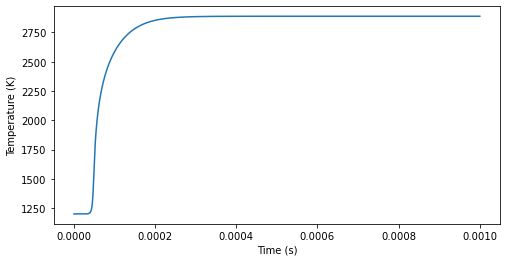

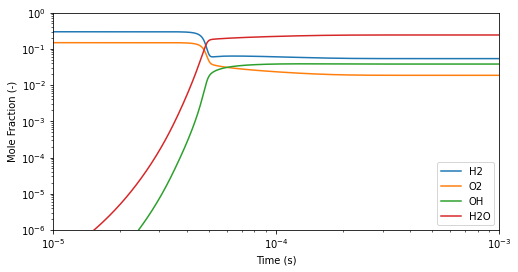

In [421]:
plt.figure(figsize=(8,4))
plt.plot(time, T)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')

plt.figure(figsize=(8,4))
for sp, x in zip(['H2', 'O2', 'OH', 'H2O'], [H2, O2, OH, H2O]):
    plt.loglog(time, x, label=sp)
plt.xlabel('Time (s)')
plt.ylabel('Mole Fraction (-)')
plt.xlim((1e-5, 1e-3))
plt.ylim((1e-6, 1))
plt.legend()

And there we have it - our first kinetic simulation time-series data!

__An aside on measuring computational efficiency__

Another option getting mole fractions would be to call `mole_fraction_dict` with no argument and use the the `get`
 method to access dictionary keys, passing the second argument `0` as a default if the key is not found
 (i.e. species doesn't appear in the `mole_fraction_dict`).

Since getting mole fractions is something that will be done many times during simulations, we might want to make sure
 we're doing this as efficiently as possible.
We can set up cells with the different access methods, using the "cell magic" `&&timeit` in a cell to tell Jupyter to
 compute how long a cell takes to run.

In [422]:
%%timeit

# return all species in the dictionary, then access the dictionary through dictionary indexing
gas.mole_fraction_dict(-1)['H2']

3.41 µs ± 216 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [423]:
%%timeit

# return only species with non-zero mole fractions, then access the dictionary with the 'get' method
gas.mole_fraction_dict().get('H2', 0)

3.18 µs ± 194 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


We see the two methods take close to the same time to run.
Another option would be to access mole fractions from the mole-fraction array.

In [424]:
%%timeit

gas.X[gas.species_index('H2')]

2.51 µs ± 236 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


This is better!
What's more, the species index doesn't change, so if we store the index to a variable at the start of the run, we can
 just reuse the variable instead of re-calling the `species_index` method repeatedly.

In [425]:
i_H2 = gas.species_index('H2')

In [426]:
%%timeit

gas.X[i_H2]

1.45 µs ± 77.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Less than half the time of our original method!?

That could add up - we'll take it!

### 2f. Storing results in a dictionary

We've seen how we can use lists to track variables at each step of a simulation run.
However, even with the relatively few variables we tracked in the last run, we ended up with a lot of variables
 floating around for all those lists.

A cleaner way to organize results would be in a `dict`, with the names of the variables as the keys and `lists` as the
 stored values.

Since we'll want a new one of these dictionaries for every simulation run, we'll write a function to initialize one.

In [427]:
def new_result_dict(sln: ct.Solution, species_list=None):
    # if the species list is None, make entries for all the species in the Solution object
    if species_list is None:
        species_list = sln.species_names
    else:  # remove any species in the list not in the Solution to prevent errors
        species_list = list(species_list)  # make sure the species_list is of type list
        for sp in species_list:
            if sp not in sln.species_names:
                print(f"{sp} not in mechanism; removed from tracked species.")
                species_list.remove(sp)

    # start initializing the dictionary with basic properties - time, temperature (T), pressure (P)
    result_dict = {'time':[],
                   'T':[],
                   'P':[]}
    # now add entries for the species
    for sp in species_list:
        result_dict[sp] = []
    # finally, add entries with a list of the species and their indices
    result_dict['species'] = species_list
    result_dict['indices'] = [sln.species_index(sp) for sp in species_list]

    return result_dict

In [428]:
# a dictionary with default arguments
new_result_dict(gas)

{'time': [],
 'T': [],
 'P': [],
 'H2': [],
 'H': [],
 'O': [],
 'O2': [],
 'OH': [],
 'H2O': [],
 'HO2': [],
 'H2O2': [],
 'N2': [],
 'AR': [],
 'species': ['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'N2', 'AR'],
 'indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [429]:
# a dictionary for a specified list of species
species_of_interest = ['H2', 'O2', 'H2O', 'OH', 'H', 'HO2']
results = new_result_dict(gas, species_of_interest)
results

{'time': [],
 'T': [],
 'P': [],
 'H2': [],
 'O2': [],
 'H2O': [],
 'OH': [],
 'H': [],
 'HO2': [],
 'species': ['H2', 'O2', 'H2O', 'OH', 'H', 'HO2'],
 'indices': [0, 3, 5, 4, 1, 6]}

We could now, also, define a function for extracting the state from a ReactorNet and Solution object at its current time
 step and append that data to the lists in our dictionary

In [430]:
def add_to_result(sln, network, res_dict):
    res_dict['time'] += [network.time]
    res_dict['T'] += [sln.T]
    res_dict['P'] += [sln.P]
    for sp, x in zip(res_dict['species'], sln.X[res_dict['indices']]):
        res_dict[sp] += [x]

And we can check that it works as we expect:

In [431]:
add_to_result(gas, rnet, results)
results

{'time': [0.001000292060426455],
 'T': [2888.5121015384298],
 'P': [101324.99999999999],
 'H2': [0.053609533654883045],
 'O2': [0.018544867904673974],
 'H2O': [0.24063005717954586],
 'OH': [0.03794192596268603],
 'H': [0.02564495037471826],
 'HO2': [8.740047412720469e-06],
 'species': ['H2', 'O2', 'H2O', 'OH', 'H', 'HO2'],
 'indices': [0, 3, 5, 4, 1, 6]}

Now we're ready to run a simulation again, which should be a lot easier this time around.

Let's see what that looks like, starting again from the beginning:

In [432]:
# setup the reactor, result objects
r1, rnet = setup_simulation(gas)
results = new_result_dict(gas, species_of_interest)

# run the simulation
t_stop = 1e-3
while rnet.time < t_stop:
    rnet.step()
    add_to_result(gas, rnet, results)

(1e-06, 1)

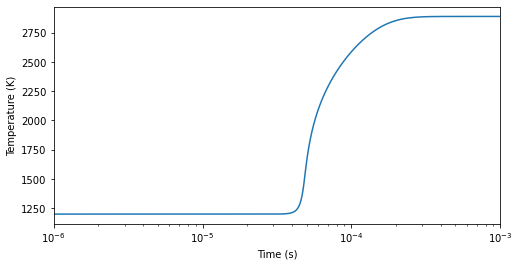

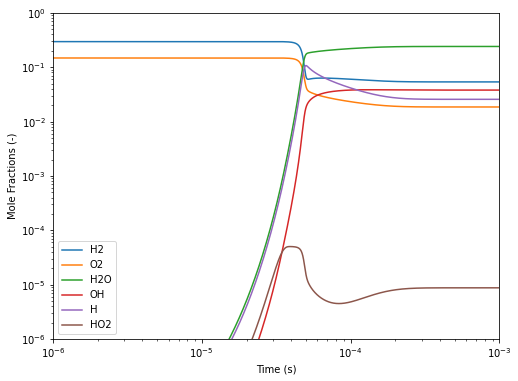

In [433]:
# check that the results look like what we expect
plt.figure(figsize=(8, 4))
plt.semilogx(results['time'], results['T'])
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.xlim((1e-6, t_stop))

plt.figure(figsize=(8, 6))
for sp in results['species']:
    plt.loglog(results['time'], results[sp], label=sp)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Mole Fractions (-)')
plt.xlim((1e-6, t_stop))
plt.ylim((1e-6, 1))

And they do!

At some time (the ignition delay time, IDT), fuel $H_2$ and oxygen $O_2$ are rapidly consumed, forming water $H_2O$
 as the primary product.
$OH$ is formed as a combustion intermediate, and persists after ignition as an equilibrium species at high temperatures.
Other radicals ($H$ and $HO_2$) reach peak concentrations at the time of ignition, settling to lower equilibrium
 concentrations at later times.

Since we'll often want to visualize results, let's wrap our plotting code into its own function:

In [434]:
def plot_simulation_result(result_dict, logx=True, tmin=1e-6, tmax=None):
    ts = result_dict['time']
    if tmax is None:
        tmax = ts[-1]

    # plot temperature vs. time
    plt.figure(figsize=(8, 4))
    if logx:
        plt.semilogx(ts, result_dict['T'])
    else:
        plt.plot(ts, result_dict['T'])
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.xlim((tmin, tmax))

    # plot mole fractions vs. time
    plt.figure(figsize=(8, 6))
    for sp in result_dict['species']:
        if logx:
            plt.loglog(ts, result_dict[sp], label=sp)
        else:
            plt.semilogy(ts, result_dict[sp], label=sp)
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Mole Fractions (-)')
    plt.ylim((1e-6, 1))
    plt.xlim((tmin, tmax))

So now we can set up, run, and visualize the results of a simulation all in just a few lines of code:

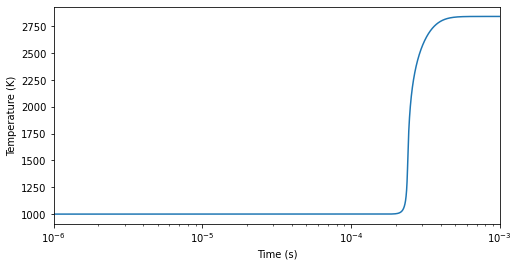

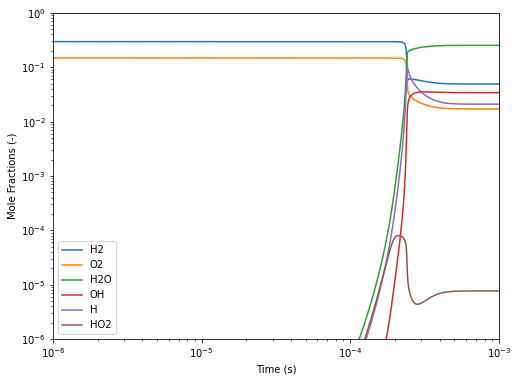

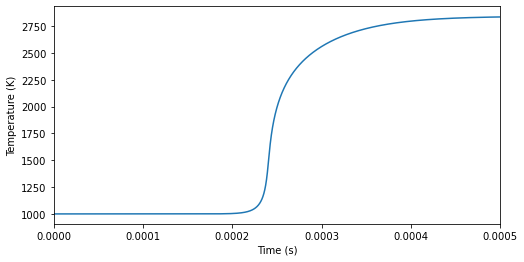

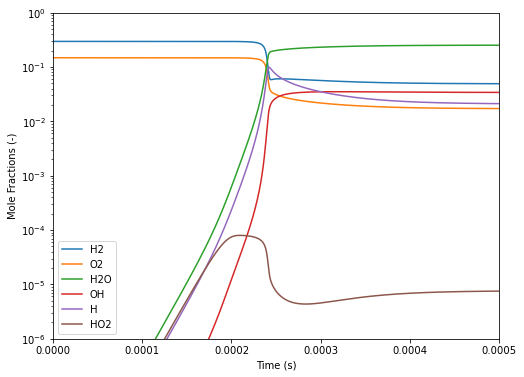

In [435]:
r1, rnet = setup_simulation(gas, T=1000)
results = new_result_dict(gas, species_of_interest)

# run the simulation
t_stop = 1e-3
while rnet.time < t_stop:
    rnet.step()
    add_to_result(gas, rnet, results)

# visualization using default arguments
plot_simulation_result(results)
# visualization with custom settings
plot_simulation_result(results, tmin=0, tmax=5e-4, logx=False)

Or, we could define a single function to do it all for us.
We'll get there in the next section...

## 3. Ignition Delay Times and Sensitivity Analysis

We've now seen how to get species and temperature time histories from a kinetic simulation.
As was introduced in the slides at the start of this problem session, we still want to be able to:
* Calculate/predict an ignition delay time $$\tau_{ign}$$ using a kinetic simulation
* Perform sensitivity analysis to determine to which reaction rates $$\tau_{ign}$$ is most sensitive

### 3a. Defining $\tau_\mathrm{ign}$:

There are a number of ways in which $\tau_{ign}$ can be defined and measured.
Experimentally, the ignition time may be measured from a rise in pressure, a rise in emission, or from a change in laser-absorption
 measurements.
These measurements can all produce slightly different results, making comparison between simulations and results
 challenging.

Similarly, a number of different values of $\tau_{ign}$ can be defined from simulation results.
For example, we could define ignition based on the peak rate of temperature increase, peak removal rate of fuel
 ($H_2$), peak production rate of products ($H_2O$), or the peak concentration of some radical species (e.g. $H$).
In a constant volume reactor, we could also use pressure, but our results have constant pressure by definition.

__Peak Radical Concentration:__

To start, we will consider the simplest definition, the peak concentration of the transient hydrogen radical.
From our time-series results, we saw that the mole fraction of atomic hydrogen peaks around the time of ignition,
 a feature that may make it a useful definition.

In order to extract the ignition time based on the maximum concentration, we can use the `argmax` function of the
 `numpy` package to get the index of the maximum value from an array.

_Note:_ While we could convert our list to an array before passing to `argmax`, this step is unnecessary, as that
 conversion is handled automatically by `numpy`.

In [436]:
# get the index of the maximum mole fraction of H
iH_max = np.argmax(results['H'])

# find the time associated with that list index
t_ign_H = results['time'][iH_max]

print(f't_ign_H = {t_ign_H*1e6:4.1f} us')

t_ign_H = 242.3 us


(0.00019384218502982442, 0.0002907632775447366)

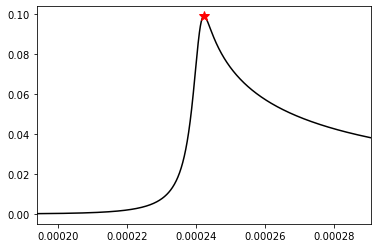

In [437]:
# plot the result to see we found the right point
plt.plot(results['time'], results['H'], '-k')
plt.plot(t_ign_H, results['H'][iH_max], '*r', ms=10)  # "ms" is the keyword argument for the "marker_size"
plt.xlim((0.8*t_ign_H, 1.2*t_ign_H))

__Peak Rate of Temperature Change:__

Another seemingly logical definition would be to consider ignition as the timing of the maximum rate of increase in
 the temperature.
To calculate the rate of change, we can again use `numpy`.
The `diff` function calculates the difference between consecutive array (or list) elements, allowing us to perform a
 numerical differentiation.

Since numerical differentiation will return one fewer element than we start with, we will also use `diff` to help
 calculate the mean time between time steps to match up with our rate of temperature change.

In [438]:
dT = np.diff(results['T'])
dt = np.diff(results['time'])

dT_dt = dT / dt
t_mean = np.array(results['time'][:-1]) + (dt / 2)

idT_max = np.argmax(dT_dt)
t_ign_dT = t_mean[idT_max]

print(f't_ign_dT = {t_ign_dT*1e6:4.1f} us')

t_ign_dT = 240.7 us


We find that the IDT calculated using the rate of temperature change is quite close to that found using the hydrogen
 radical, with a difference of only about 1%.

We can visualize this result as well; this time, we choose to do that a little differently:

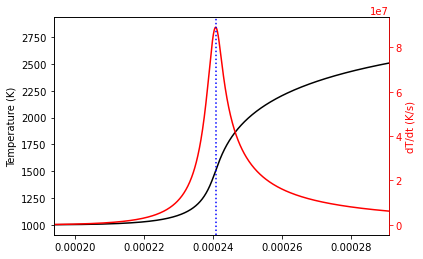

In [439]:
# visualize the result
#   first plot the raw temperature vs. time
plt.plot(results['time'], results['T'], '-k', label='T')
plt.ylabel('Temperature (K)')
plt.xlim((0.8*t_ign_H, 1.2*t_ign_H))
#   next we'll overlay a second y-axis and plot the dT/dt
plt.twinx()
plt.plot(t_mean, dT_dt, '-r', label='dT/dt')
plt.ylabel('dT/dt (K/s)')
#   the following lines just make the right axis red to match the data
plt.gca().spines['right'].set_color('r')
plt.gca().tick_params(axis='y', colors='r')
plt.gca().yaxis.label.set_color('red')
#   lastly, we'll add a vertical line marking the ignition time
plt.axvline(t_ign_dT, label='t_ign', c='b', ls=':')

We can use the same type of analysis as we did for temperature to look at ignition times based on fuel consumption and
 product formation.
We'll define some functions to make calculating IDTs easier to do repeatedly.

In [440]:
def idt_x_max(result_dict, x_key, save_to_dict=True, print_out=False):
    x = result_dict[x_key]

    ix_max = np.argmax(x)  # flips the sign of dx_dt if keyword arg "sign" is negative
    t_ign_x = result_dict['time'][ix_max]

    if print_out:
        print(f'IDT_{x_key+"_max":10s} = {t_ign_x*1e6:4.1f} us')

    if save_to_dict:
        idt_dict = result_dict.get('idt', {})
        idt_dict[x_key] = t_ign_x
        result_dict['idt'] = idt_dict

def idt_dx_dt(result_dict, x_key, sign=1, save_to_dict=True, print_out=False):
    dx = np.diff(result_dict[x_key])
    dt = np.diff(result_dict['time'])

    dx_dt = dx / dt
    t_mean = np.array(result_dict['time'][:-1]) + (dt / 2)

    idx_max = np.argmax(np.sign(sign) * dx_dt)  # flips the sign of dx_dt if keyword arg "sign" is negative
    t_ign_dx = t_mean[idx_max]

    if print_out:
        print(f'IDT_d{x_key+"/dt":9s} = {t_ign_dx*1e6:4.1f} us')

    if save_to_dict:
        idt_dict = result_dict.get('idt', {})
        idt_dict[x_key] = t_ign_dx
        result_dict['idt'] = idt_dict

These two functions allow us to calculate any number of IDTs, adding them to the result dictionary:

In [441]:
idt_x_max(results, 'H', print_out=True)
idt_dx_dt(results, 'T', print_out=True)
idt_dx_dt(results, 'H2', sign=-1, print_out=True)
idt_dx_dt(results, 'H2O', print_out=True)

results['idt']

IDT_H_max      = 242.3 us
IDT_dT/dt      = 240.7 us
IDT_dH2/dt     = 240.1 us
IDT_dH2O/dt    = 240.1 us


{'H': 0.0002423027312872805,
 'T': 0.00024073637644344181,
 'H2': 0.00024007975276468617,
 'H2O': 0.00024012635747999413}

And all these definitions can be bundled into a function to calculate all the IDTs for a given result:

In [442]:
def calculate_idt(result_dict):
    idt_dx_dt(result_dict, 'T')
    idt_x_max(result_dict, 'H')
    idt_dx_dt(result_dict, 'H2', sign=-1)
    idt_dx_dt(result_dict, 'H2O')

In [443]:
calculate_idt(results)
results['idt']

{'H': 0.0002423027312872805,
 'T': 0.00024073637644344181,
 'H2': 0.00024007975276468617,
 'H2O': 0.00024012635747999413}

### 3b. Temperature Dependence of $\tau_\mathrm{ign}$

We may want to see how the ignition delay time varies with temperature.
To do this, we'll bundle everything required to run and analyze a simulation into a single function, then run this
 function repeatedly at different initial temperatures.

To start, let's define the function, which will accept and pass through many of the optional, keyword arguments
 we have been implementing along the way:

In [444]:
T0 = 1200  # K
P0 = 101325  # Pa (1 atm)
phi = 1.
fuel = {'H2':1.}
oxidizer = {'AR':.79, 'O2':.21}  # "airgon"

def simulate_idt(sln, T=T0, P=P0, phi=phi, f=fuel, ox=oxidizer, species_of_interest=None, t_stop=1e-3):

    # setup the reactor, result objects
    r1, rnet = setup_simulation(gas, T=T, P=P, phi=phi, f=f, ox=ox)
    results = new_result_dict(gas, species_list=species_of_interest)

    # run the simulation
    while rnet.time < t_stop:
        rnet.step()
        add_to_result(gas, rnet, results)

    calculate_idt(results)

    return results['idt']

We can then run our IDT calculation function over a range of initial temperatures...

In [445]:
Ts = np.arange(1100, 1801, 100)
print(Ts)

idt_list = []
for T in Ts:
    idt_list += [simulate_idt(gas, T=T)]

idt_list

[1100 1200 1300 1400 1500 1600 1700 1800]


[{'T': 9.17754656275163e-05,
  'H': 9.326319072229984e-05,
  'H2': 9.11192227682259e-05,
  'H2O': 9.119705409731596e-05},
 {'T': 4.878920933455697e-05,
  'H': 5.0194652385921754e-05,
  'H2': 4.8140543310850136e-05,
  'H2O': 4.8202321027393644e-05},
 {'T': 2.9664315185427656e-05,
  'H': 3.094529898690091e-05,
  'H2': 2.893124397382881e-05,
  'H2O': 2.9002186349144826e-05},
 {'T': 1.951193744368907e-05,
  'H': 2.072660308133192e-05,
  'H2': 1.8818388363227175e-05,
  'H2O': 1.884831871527611e-05},
 {'T': 1.3566490615300592e-05,
  'H': 1.4719496422852928e-05,
  'H2': 1.294267915758394e-05,
  'H2O': 1.2969960067624414e-05},
 {'T': 9.783242515528399e-06,
  'H': 1.094443391691909e-05,
  'H2': 9.31311396645162e-06,
  'H2O': 9.340208907247125e-06},
 {'T': 7.25116141285698e-06,
  'H': 8.457403590774216e-06,
  'H2': 6.961616423284827e-06,
  'H2O': 6.9809194225896365e-06},
 {'T': 5.50379977117007e-06,
  'H': 6.731690224802844e-06,
  'H2': 5.347047798365887e-06,
  'H2O': 5.364464684233017e-06}]

And plot our results on an Arrhenius-type diagram

Text(0, 0.5, 'IDT (s)')

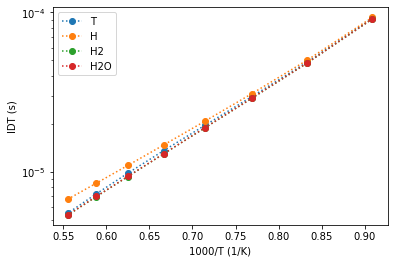

In [446]:
for key in idt_list[0].keys():
    idts = [idt_dict[key] for idt_dict in idt_list]
    plt.semilogy(1000/Ts, idts, ':o', label=str(key))

plt.legend()
plt.xlabel('1000/T (1/K)')
plt.ylabel('IDT (s)')

From this diagram, we can make a few observations:
1. IDTs defined using temperature, fuel, and water closely agree
2. IDT defined using hydrogen radicals are systematically longer
3. The IDTs closely follow an Arrhenius trend

This last point suggests that the ignition delay time might be defined well be an Arrhenius-type expression, allowing
 the IDT (a global parameter) to be associated with a characteristic activation energy.
You will be asked to calculate such an activation energy as part of the problem set.

### 3c. $\tau_\mathrm{ign}$ Sensitivity Analysis

Now that we know how to calculate an IDT, we can look at how to calculate the sensitivity of the ignition delay time
 to changes in reaction rates.

If we were using Chemkin II (the old, free version we used to teach in ME362B), you would do this by manually
 editing the mechanism text file between each simulation -- not fun!

Fortunately, Cantera makes it much easier to change reaction rates by adjusting a multiplier assigned to each rate using
 the `set_multiplier` method.

To calculate the sensitivity, we perturb one reaction at a time by some small, fractional amount $f_k = dk_j / k_j$.
We then compare the IDTs between the base (unperturbed) mechanism and that with the rate changed.

We'll first calculate the sensitivity of IDT to the first reaction in the mechansim at T = 1200 K and P = 1 atm.

In [447]:
# calculate the base result
T_sens = 1200
P_sens = 101325
IDT_def = 'T'  # this is the definition of IDT we'll use in our analysis

gas.set_multiplier(1.)  # this makes sure all the multipliers are set to 1.
IDT_base = simulate_idt(gas, T=T_sens, P=P_sens)[IDT_def]

# perturb the mechanism and calculate the new IDT
f_k = 0.05
i_rxn = 0
gas.set_multiplier((1+f_k), i_rxn)
IDT_sens = simulate_idt(gas, T=T_sens, P=P_sens)[IDT_def]

# calculate the IDT sensitivity
dIDT_IDT = (IDT_sens - IDT_base) / IDT_base
sensitivity = dIDT_IDT / f_k
print(f'[{i_rxn}] {gas.reaction_equation(i_rxn)}: Sensitivity = {sensitivity:4.3f}')

[0] H + O2 <=> O + OH: Sensitivity = -0.693


This tells us that increasing the rate of the first reaction in the mechanism results in a _decreasing_ the IDT
(i.e. _faster_ ignition).

We can now just wrap this calculation in a `for` loop over all the reactions in the mechanism.
Here, we'll store all the IDTs in an array as we go, then calculate our sensitivities at the end.

In [448]:
# calculate the base result
T_sens = 1200
P_sens = 101325
IDT_def = 'T'  # this is the definition of IDT we'll use in our analysis

gas.set_multiplier(1.)  # this makes sure all the multipliers are set to 1.
IDT_base = simulate_idt(gas, T=T_sens, P=P_sens)[IDT_def]

# perturb the mechanism and calculate the new IDT
f_k = 0.05
IDT_sens = np.zeros(gas.n_reactions, dtype=float)

for i in range(gas.n_reactions):
    gas.set_multiplier(1)
    gas.set_multiplier((1+f_k), i)
    IDT_sens[i] = simulate_idt(gas, T=T_sens, P=P_sens)[IDT_def]

# calculate the IDT sensitivity
dIDT_IDT = (IDT_sens - IDT_base) / IDT_base
sensitivities = dIDT_IDT / f_k

print(sensitivities)

[-6.93069791e-01  3.14299379e-02  1.66579261e-02  5.10442167e-03
 -9.37311186e-03  4.62254178e-04  2.74985394e-04  9.95736586e-05
  6.91715220e-03  5.34601553e-04  4.29482772e-03  6.86780574e-03
  1.34096043e-02  1.15441746e-02 -5.48654151e-02 -1.11766175e-01
 -5.18083052e-02 -8.29877365e-03  8.07849112e-04 -4.15294149e-02
  4.97606277e-03  4.09275463e-03  8.15167760e-03  4.08343987e-05
  9.54848101e-03  6.42382807e-03  0.00000000e+00  1.07582604e-03
 -5.78119500e-04  7.61329629e-03  1.06415946e-02]


Which now gives us an array of sensitivities, indexed in order of the reactions in the mechanism.

In order to visualize these results, a horizontal bar plot is conventionally used.
We first sort the reactions and their equations by the sensitivity, using `np.argsort` to get a sorted list of indices.

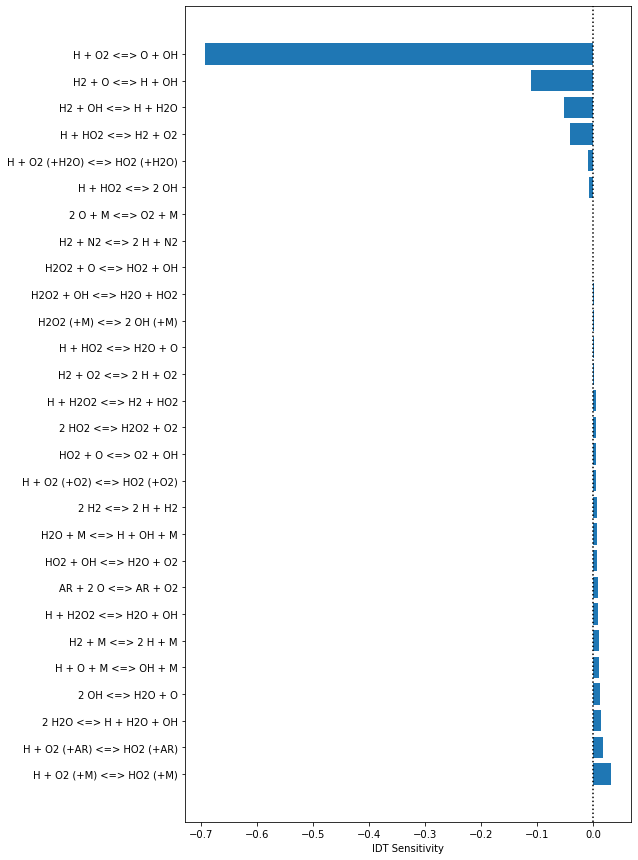

In [449]:
i_sort = np.argsort(sensitivities)[::-1]

sorted_sens = sensitivities[i_sort]
sorted_eqns = np.array(gas.reaction_equations(i_sort))

plt.figure(figsize=(8, 15))
plt.barh(sorted_eqns, sorted_sens)
plt.xlabel('IDT Sensitivity')
plt.axvline(0, ls=':', c='k')

At the top, we see a few reactions display negative sensitivies;
 increasing the rate of these reactions increases the rate at which ignition occurs.

Many of the reactions, however, display (small) positive sensitivities;
 increasing the rate of these reactions actually slows down the rate at which ignition occurs.

The problem set will ask you to calculate sensitivities for a different reactive system and comment on why some
 reactions promote (speed up) ignition while others inhibit it.

We may find it more helpful to only view a subset of the most sensitive reactions in performing an analysis.

One way to do this would be to only show sensitivities with a magnitude above a certain threshold using boolean
 indexing:

_Note:_ To use boolean indexing, our sensitivies and equantion names must be in the form of numpy arrays, **not** lists.
Lists do not support boolean indexing.

In [450]:
threshold_sens = 0.01

above_thresh = np.abs(sorted_sens) > threshold_sens
above_thresh

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True])

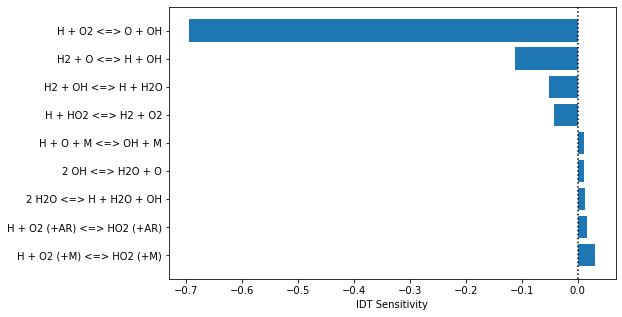

In [451]:
plt.figure(figsize=(8, 5))
plt.barh(sorted_eqns[above_thresh], sorted_sens[above_thresh])
plt.xlabel('IDT Sensitivity')
plt.axvline(0, ls=':', c='k')

Alternatively, we can use sorting to show only a certain number of the most sensitive reactions:

In [452]:
n_max = 6

i_abs_sort = np.argsort(np.abs(sensitivities))[::-1]  # flip the order to sort from high to low
n_max_sens = sensitivities[i_abs_sort[:n_max]]
n_max_eqns = np.array(gas.reaction_equations(i_abs_sort[:n_max]))

i_sort_nmax = np.argsort(n_max_sens)[::-1]
n_sort_sens = n_max_sens[i_sort_nmax]
n_sort_eqns = n_max_eqns[i_sort_nmax]

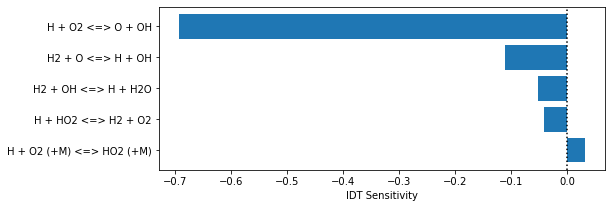

In [453]:
plt.figure(figsize=(8, 3))
plt.barh(n_sort_eqns, n_sort_sens)
plt.xlabel('IDT Sensitivity')
plt.axvline(0, ls=':', c='k')

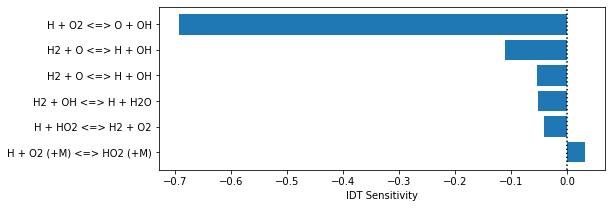

In [454]:
plt.figure(figsize=(8, 3))
plt.barh(range(len(n_sort_sens)), n_sort_sens)
plt.yticks(range(len(n_sort_sens)), n_sort_eqns)
plt.xlabel('IDT Sensitivity')
plt.axvline(0, ls=':', c='k')

The difference between the two plots above is how we handle passing y-values to the `barh` function.

In the first cell, we pass the array `n_sort_eqns`, and end up with one less bar than we were expecting.

In the cell immediately above, we instead pass `range(len(n_sort_sens))` as the y-values, then relabel the ticks with
 the `n_sort_eqns` array.

Doing this reveals that their is a duplicate reaction $H2 + O <=> H + OH$ in the mechanism.
Because y-values cannot be repeated, one is excluded in the first plot, where the strings define the y values.
In the second plot, sensitivities are ploted against numbers, that are only relabeled with strings, so they both appear.

**An Aside: Evaluating Elementary Reaction Rates**

Let's take a quick pause to look at why there might be two of the same reaction in the mechanism.
We have already seen how to get all the reaction strings from a Solution object:

In [461]:
gas.reaction_equations()

['H + O2 <=> O + OH',
 'H + O2 (+M) <=> HO2 (+M)',
 'H + O2 (+AR) <=> HO2 (+AR)',
 'H + O2 (+O2) <=> HO2 (+O2)',
 'H + O2 (+H2O) <=> HO2 (+H2O)',
 'H2O2 (+M) <=> 2 OH (+M)',
 'H2O2 + OH <=> H2O + HO2',
 'H2O2 + OH <=> H2O + HO2',
 'HO2 + OH <=> H2O + O2',
 '2 HO2 <=> H2O2 + O2',
 '2 HO2 <=> H2O2 + O2',
 'H2O + M <=> H + OH + M',
 '2 H2O <=> H + H2O + OH',
 '2 OH <=> H2O + O',
 'H2 + O <=> H + OH',
 'H2 + O <=> H + OH',
 'H2 + OH <=> H + H2O',
 'H + HO2 <=> 2 OH',
 'H + HO2 <=> H2O + O',
 'H + HO2 <=> H2 + O2',
 'HO2 + O <=> O2 + OH',
 'H + H2O2 <=> H2 + HO2',
 'H + H2O2 <=> H2O + OH',
 'H2O2 + O <=> HO2 + OH',
 'H2 + M <=> 2 H + M',
 '2 H2 <=> 2 H + H2',
 'H2 + N2 <=> 2 H + N2',
 'H2 + O2 <=> 2 H + O2',
 '2 O + M <=> O2 + M',
 'AR + 2 O <=> AR + O2',
 'H + O + M <=> OH + M']

Looking at the whole list, there are actually multiple duplicates:

We can get a list of the reactions with duplicates by extracting reactions for which the`duplicate` property is `True`.

In [464]:
dup_rxns = [rxn  for rxn in gas.reactions() if rxn.duplicate]
dup_rxns

[<ElementaryReaction: H2O2 + OH <=> H2O + HO2>,
 <ElementaryReaction: H2O2 + OH <=> H2O + HO2>,
 <ElementaryReaction: 2 HO2 <=> H2O2 + O2>,
 <ElementaryReaction: 2 HO2 <=> H2O2 + O2>,
 <ElementaryReaction: H2 + O <=> H + OH>,
 <ElementaryReaction: H2 + O <=> H + OH>]

In the above cell, we've built our list of reaction objects, not just strings, so we get additional details (e.g. that
 they are all `ElementaryReaction` type) and access to additional properties and methods.

In [473]:
T_k = 1000
for r in dup_rxns:
    print(r)
    print(f'    {r.rate}')
    print(f'    k({T_k} K) = {r.rate(T_k):4.3e}')

H2O2 + OH <=> H2O + HO2
    Arrhenius(A=7.586e+10, b=0, E=3.04135e+07)
    k(1000 K) = 1.956e+09
H2O2 + OH <=> H2O + HO2
    Arrhenius(A=1.738e+09, b=0, E=1.33051e+06)
    k(1000 K) = 1.481e+09
2 HO2 <=> H2O2 + O2
    Arrhenius(A=1.3e+08, b=0, E=-6.70695e+06)
    k(1000 K) = 2.913e+08
2 HO2 <=> H2O2 + O2
    Arrhenius(A=4.2e+11, b=0, E=5.01243e+07)
    k(1000 K) = 1.012e+09
H2 + O <=> H + OH
    Arrhenius(A=3.82e+09, b=0, E=3.32544e+07)
    k(1000 K) = 6.999e+07
H2 + O <=> H + OH
    Arrhenius(A=8.79e+11, b=0, E=8.02073e+07)
    k(1000 K) = 5.682e+07


We can see all of these reactions are expressed in Arrhenius form ($b=0$), and that the duplicated reactions have
 very different pre-exponential $A$ and activation-energy $E$ values.

In order to see why duplicate reactions might be included in a mechanism, let's plot them as pairs on an Arrhenius
 plot.
We'll also plot the sum of the two rates, to see the net effect of including both reactions.

Text(0.5, 0, 'Temperature, T (K)')

C:\Users\asusa\.conda\envs\me362b\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


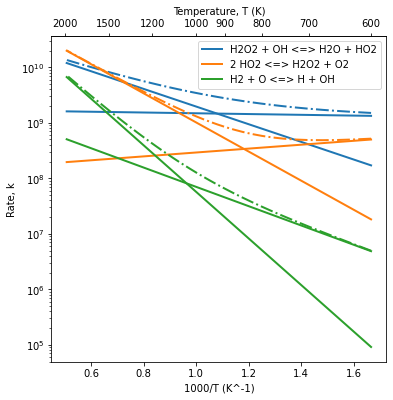

In [499]:
def plot_dup_rxn_pair(rxns, Ts):
    sum_ks = np.zeros_like(Ts)
    for i, r in enumerate(rxns):
        ks = np.zeros_like(Ts)
        for j, T in enumerate(Ts):
            ks[j] = r.rate(T)
        sum_ks += ks
        if i == 0:  # only label the first instance of a reaction
            h = plt.semilogy(1000/Ts, ks, ls='-', lw=2, label=str(r))[0]
        else:  # use the same color for later instances
            plt.semilogy(1000/Ts, ks, ls='-', lw=2, c=h.get_color())
    plt.semilogy(1000/Ts, sum_ks, ls='-.', lw=2, c=h.get_color())

Ts_rxn = np.arange(600, 2000, 25, dtype=float)
plt.figure(figsize=(6, 6))
for i in range(3):
    j = i*2
    plot_dup_rxn_pair(dup_rxns[j:j+2], Ts_rxn)
plt.legend()
plt.xlabel('1000/T (K^-1)')
plt.ylabel('Rate, k')
secx = plt.gca().secondary_xaxis('top', functions=(lambda x: 1000/ x, lambda x: 1000/ x))
secx.set_xticks([2000, 1500, 1200, 1000, 900, 800, 700, 600])
secx.set_xlabel('Temperature, T (K)');

By visualizing the actual rates, we see that including a reaction twice provides a diffent method to capture
 non-Arrhenius behavior.
At high temperatures, the reaction follows the rate described by the higher activation energy;
At low temperatures, the net rate follows that of the lower activation energy.
At intermediate temperatures near a crossover point, both rates contribute, and the net rate shows curvature
 (i.e. non-Arrhenius behavior).

### 3d. Temperature Dependence of IDT Sensitivity

In kinetics research, we often want to know how the relative importance of reactions changes with different
 conditions (e.g. temperature, pressure, equivalence ratio, oxygen mole fraction, etc.) or varies between different
 kinetic mechanisms.

Our last example in this notebook will demonstrate how you might look at how IDT sensitivity changes with temperature.
In your problem set, you will be asked to perform a similar analysis but while varying a different parameter.

As has been the case throughout this notebook, we'll define a function to do basically all our work for us.
In this case, at a given set of conditions, we'll have our function calculate all our sensitivities and optionally
 produce a plot of the most important reactions.

In [455]:
# we redefine our base parameters for good measure
T0 = 1200  # K
P0 = 101325  # Pa (1 atm)
phi = 1.
fuel = {'H2':1.}
oxidizer = {'AR':.79, 'O2':.21}  # "airgon"

# then define our function, taking advantage of those we have already written
def calculate_sensitivities(sln, T=T0, P=P0, phi=phi, f=fuel, ox=oxidizer, t_stop=1e-3,
                            plot_result=True, n_sens_max=10, title=None, IDT_def='T'):
    # calculate the base result
    sln.set_multiplier(1.)  # this makes sure all the multipliers are set to 1.
    IDT_base = simulate_idt(sln, T=T, P=P, phi=phi, f=f, ox=ox, t_stop=t_stop)[IDT_def]

    # perturb the mechanism and calculate the new IDT
    f_k = 0.05
    IDT_sens = np.zeros(sln.n_reactions, dtype=float)

    for i in range(sln.n_reactions):
        sln.set_multiplier(1)
        sln.set_multiplier((1+f_k), i)
        IDT_sens[i] = simulate_idt(sln, T=T, P=P, phi=phi, f=f, ox=ox, t_stop=IDT_base*3)[IDT_def]

    # calculate the IDT sensitivity
    dIDT_IDT = (IDT_sens - IDT_base) / IDT_base
    sensitivities = dIDT_IDT / f_k

    if plot_result:
        i_abs_sort = np.argsort(np.abs(sensitivities))[::-1]  # flip the order to sort from high to low
        n_max_sens = sensitivities[i_abs_sort[:n_sens_max]]
        numbered_eqns = [f'{eqn} (r{i})' for i, eqn in enumerate(gas.reaction_equations())]
        n_max_eqns = np.array(numbered_eqns)[i_abs_sort[:n_sens_max]]

        i_sort_nmax = np.argsort(n_max_sens)[::-1]
        n_sort_sens = n_max_sens[i_sort_nmax]
        n_sort_eqns = n_max_eqns[i_sort_nmax]

        plt.figure(figsize=(8, n_sens_max/2))
        plt.barh(range(len(n_sort_sens)), n_sort_sens)
        plt.yticks(range(len(n_sort_sens)), n_sort_eqns)
        plt.xlabel('IDT Sensitivity')
        plt.axvline(0, ls=':', c='k')

        if title is not None:
            plt.title(title)

    return sensitivities

Let's try the new mega-function:

array([-6.30532057e-01, -1.83058270e-02,  7.71997480e-03, -1.53951888e-02,
       -6.22408463e-03, -4.64823499e-03, -2.04531387e-04, -4.75881564e-05,
       -1.32507962e-03, -9.61669007e-03, -1.20646603e-02,  7.11920645e-04,
        8.87779296e-04,  9.37627546e-04, -1.55290646e-02, -1.56412053e-01,
       -1.25552003e-01, -1.22781868e-02,  5.54183606e-03, -6.35402112e-02,
        5.21649755e-03,  7.94795245e-03,  6.58332544e-03, -1.79805614e-06,
        1.52046886e-02, -1.97568096e-03,  0.00000000e+00,  8.72439553e-03,
       -1.85501147e-02,  8.37973242e-04,  1.26392219e-04])

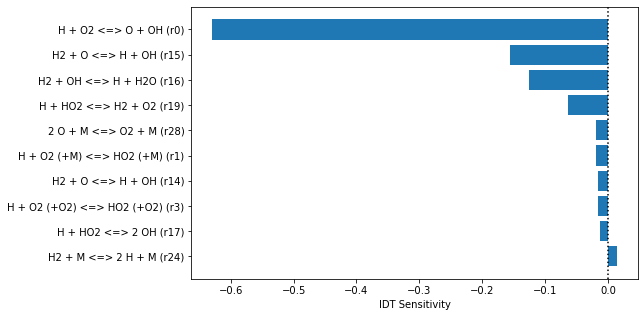

In [456]:
calculate_sensitivities(gas, T=1500)

That's a lot of analysis packed into one line of code!

As a final step, let's wrap it into a loop and see how the most sensitive reactions change with temperature.

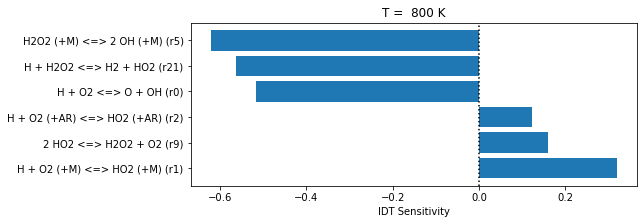

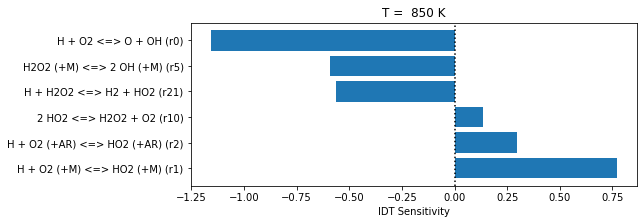

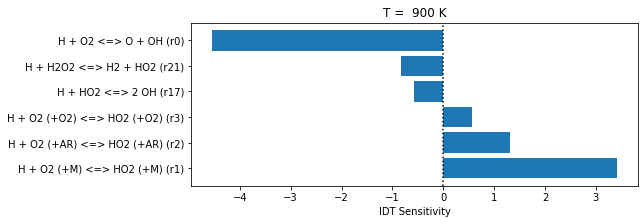

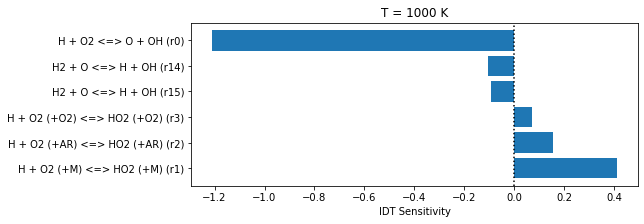

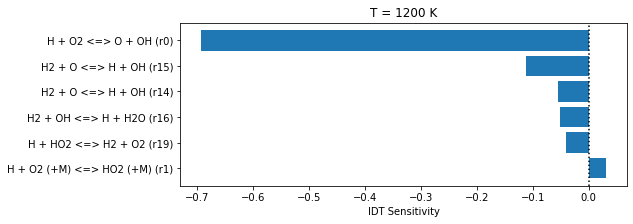

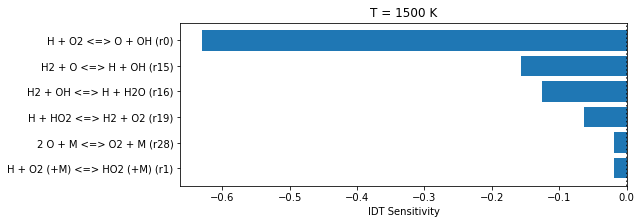

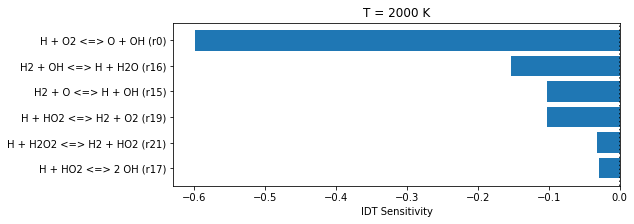

In [457]:
Ts = [800, 850, 900, 1000, 1200, 1500, 2000]

for T in Ts:
    calculate_sensitivities(gas, T=T, title=f'T = {T:4.0f} K', t_stop=20, n_sens_max=6)
